# Calculate advection in ANHA4

In [14]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts

In [15]:
import glob
import datetime
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [2]:
def central_diff(T):
    '''
    % =========================================================================== %
    % Central diffference for inner domain; forward/backward difference for edges 
    %   build-in function
    % =========================================================================== %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/25
    % =========================================================================== %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    # Get the length of x, y dimension
    M = np.size(T, axis=0)
    N = np.size(T, axis=1)
    # Allocation
    dx = np.zeros(T.shape)
    dy = np.zeros(T.shape)
    # dx
    dx[:, 0] = T[:, 1]-T[:, 0]
    dx[:,-1] = T[:,-1]-T[:,-2]
    for i in range(1, N-1):
        dx[:, i] = 0.5*(T[:, i+1]-T[:, i-1])
    # dy
    dy[0, :] = T[1, :]-T[0, :]
    dy[-1,:] = T[-1,:]-T[-2,:]
    for i in range(1, M-1):
        dy[i, :] = 0.5*(T[i+1, :]-T[i-1, :])
    return dx, dy

In [3]:
def dx_atmos(lon, lat):
    '''
    % ======================================================================= %
    % Calculate the grid distance on the earth,
    %   dy=dx*h1, h1=R*sin(phi)=R*cos(lat)
    %       (h1 is the scale factor in spherical coordinate)
    %   build-in function
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/25
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    R = 6.3781e6 # earth radius (m)
    dx, _ = central_diff(lon)
    dx = dx * (np.pi/180.0)*R*np.cos(lat*np.pi/180.0)
    return dx

In [4]:
def dy_atmos(lat):
    '''
    % ======================================================================= %
    % Calculate grid distance on Earth, 
    %   dy=dy*h2, h2=R
    %       (h2 is scale factor in spherical coordinate)
    %   build-in function
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/25
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    R = 6.3781e6 # earth radius (m)
    _, dy = central_diff(lat)
    dy = dy*(np.pi/180.0)*R
    return dy
    

In [24]:
def advh_atmos(lon, lat, u, v, T):
    '''
    % ======================================================================= %
    % Calculate horizontal advection
    % Input
    %   longitude: Longitude, deg
    %   latitude: Latitude, deg
    %   u: Zonal Wind, m/s
    %   v: Meditorial Wind, m/s
    %   T: Scalar field
    % Output
    %   advh: Horizontal Advection of T, unit(T)*s^-1
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/02/27
    % ======================================================================= %
    Rewrite in Python 2.7, 2016/04/20
        yingkai@eos.ubc.ca
    '''
    R=6.3781e6 # earth radius (m)
    dx = dx_atmos(lon, lat)
    dy = dy_atmos(lat)
    dTx, dTy = central_diff(T)
    advh=-(v*dTy/dy+u*dTx/dx)
    return advh

# A test of dx, dy

In [6]:
x = np.linspace(-180, 180, 180)
y = np.linspace(0, 90, 45)
lon, lat = np.meshgrid(x, y)

In [7]:
dx = dx_atmos(lon, lat)
dy = dy_atmos(lat)

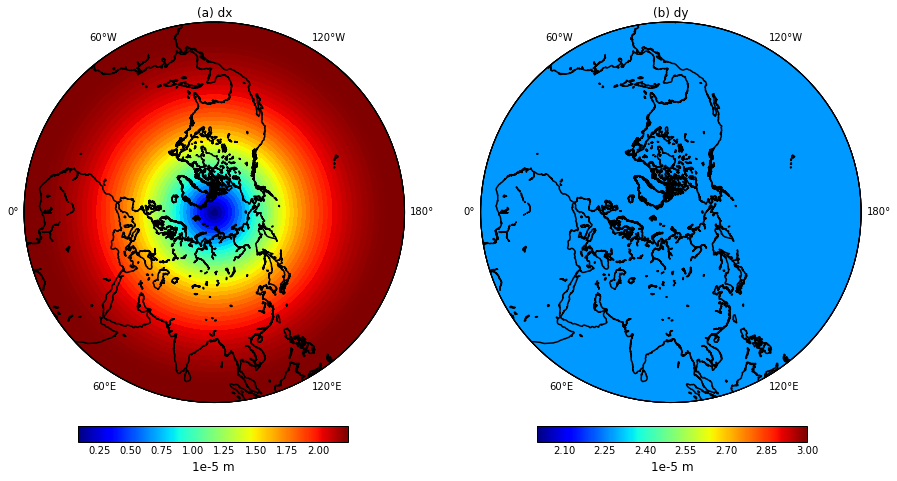

In [8]:
fig=plt.figure(figsize=(15, 15))

ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

proj=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.drawcoastlines(linewidth=1.5, color='k', zorder=4)
x, y = proj(lon, lat)
CS = proj.pcolor(x, y, dx*1e-5, cmap=plt.cm.jet)
#proj.plot(x, y, 'k-', lw=0.25); proj.plot(x.T, y.T, 'k-', lw=0.25);
ax1.set_title('(a) dx')

cax = fig.add_axes([0.175, 0.3, 0.25, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('1e-5 m', fontsize=12)
CBar.ax.tick_params(axis='x', length=0)

proj=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.drawcoastlines(linestyle='-', color='k', linewidth=1.5, zorder=3)
x, y = proj(lon, lat)
CS = proj.pcolor(x, y, dy*1e-5, vmin=2, vmax=3, cmap=plt.cm.jet)
#proj.plot(x, y, 'k-', lw=0.25); proj.plot(x.T, y.T, 'k-', lw=0.25);
ax2.set_title('(b) dy')

cax = fig.add_axes([0.6, 0.3, 0.25, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('1e-5 m', fontsize=12)
CBar.ax.tick_params(axis='x', length=0)

# Ba

In [41]:
my_y

array([ 60.        ,  60.68181818,  61.36363636,  62.04545455,
        62.72727273,  63.40909091,  64.09090909,  64.77272727,
        65.45454545,  66.13636364,  66.81818182,  67.5       ,
        68.18181818,  68.86363636,  69.54545455,  70.22727273,
        70.90909091,  71.59090909,  72.27272727,  72.95454545,
        73.63636364,  74.31818182,  75.        ,  75.68181818,
        76.36363636,  77.04545455,  77.72727273,  78.40909091,
        79.09090909,  79.77272727,  80.45454545,  81.13636364,
        81.81818182,  82.5       ,  83.18181818,  83.86363636,
        84.54545455,  85.22727273,  85.90909091,  86.59090909,
        87.27272727,  87.95454545,  88.63636364,  89.31818182,  90.        ])

In [87]:
my_x = np.linspace(-180, 180, 180)
my_y = np.linspace(60, 90, 60)
mylon, mylat = np.meshgrid(my_x, my_y)

In [52]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BARIUM01_1m_20020101_20140103_ptrc_T.nc'

In [73]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][0, 0, :, :])
#d18O = np.squeeze(ptrc_obj.variables['d18O'][:, 0, :, :])
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [90]:
Ba[Ba==0]=np.nan
Ba_int = Nts.reporj_NEMOgrid(nav_lon, nav_lat, Ba, mylon, mylat, method='linear')
Ba_int2 = Nts.reporj_NEMOgrid(nav_lon, nav_lat, Ba, mylon, mylat, method='nearest')

id1 = np.logical_and(np.isnan(Ba_int), np.abs(mylon)>90)
id2 = np.logical_and(np.isnan(Ba_int), (mylat)>61)
Ba_int[id1]=Ba_int2[id1]
Ba_int[id2]=Ba_int2[id2]

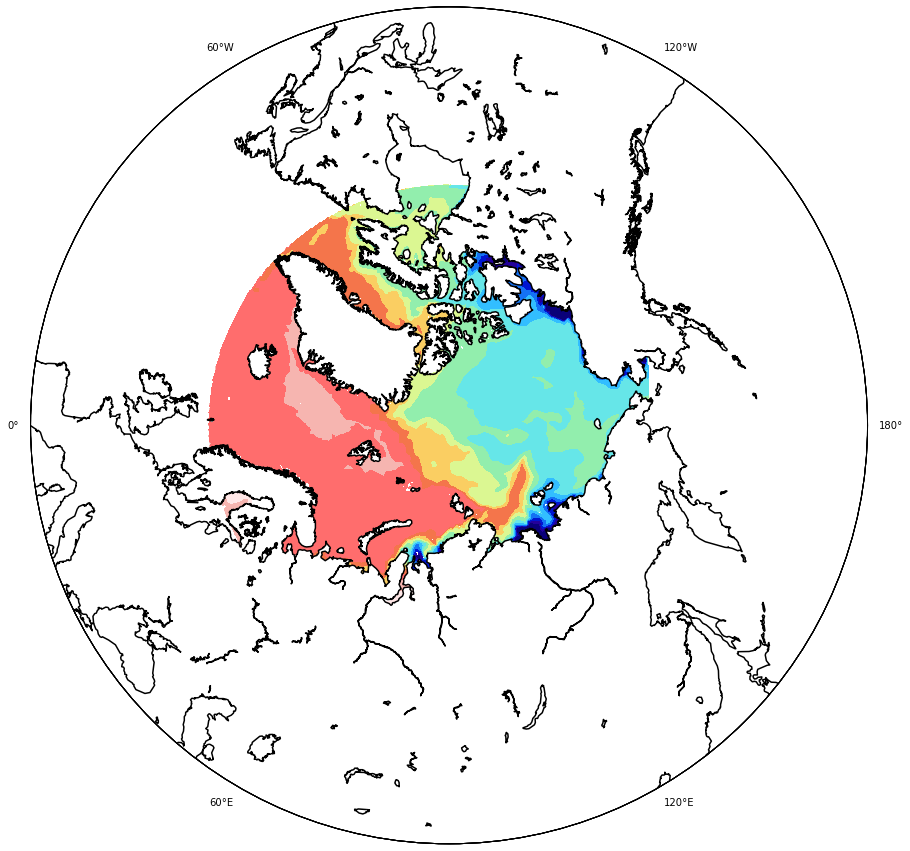

In [94]:
lev1 = np.arange(35, 100, 5)
fig=plt.figure(figsize=(15, 15))

ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=40, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.drawcoastlines(linewidth=1.5, color='k', zorder=4)
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, Ba, lev1, cmap=cm.GMT_haxby_r, extend='both')
#proj.plot(x, y, 'k-', lw=0.25); proj.plot(x.T, y.T, 'k-', lw=0.25);
ax1.set_title('(a) dx')